Libraries and modules

In [1]:
import matplotlib.pylab as plt
import numpy as np
import xarray as xr
import pandas as pd
from scipy.signal import sosfilt, iirfilter, zpk2sos
from datetime import datetime
# pytz for removing time zone info from datetime
import pytz

In [2]:
from xdas.io.febus import read as read_das
from xdas.io.febus import correct_gps_time

Pathes

In [29]:
user = 'ipgp'

if user == 'ipgp':
    path1 = '/localstorage/hugonnet/DAS_2022/' #path to h5-file 
    path2 = '/home/hugonnet/Documents/DAS-Lucie/fichiers-nc/' # path for new nc-file
    path3 = '/net/runic/moby/data/projets/monidas/biagioli/Geolocation_DAS/2022/' # path to geolocation information of the fiber

elif user == 'eleonore' :
    path1 = '/Users/stutz/DAS/DAS_STROMBOLI/2022_STROMBOLI_MANIP/SILIXA_iDAS/DATA_VLP_FEBUS/' #path to h5-file 
    path2 = path1 # path for new nc-file
    path3 = path1 # path to geolocation information of the fiber
    
elif user == 'mba' :
    path1 = '' #path to h5-file 
    path2 = '' # path for new nc-file
    path3 = '' # path to geolocation information of the fiber

## Rewriting data from h5 format into dataset (and to nc format)

Advantages: data is easier to read and size is reduced by a factor of 2. <br> Indeed, in the h5 format, data are separated in 1 s long recordings, all of whom come with 1/2 s of recording before and 1/2 s of recording after the 1 s bit of data. Each piece is therefore in fact a 2 s long recording, and the file contains the data twice. The rewriting we're operating in this code enables us to get rid of the unnecessary pieces of information, thereby reducing the size of the file by a factor of 2.

Code partly taken from script 02_read_febus_VLP_write_noverlap written by Francesco Biagioli

### Reading of the file

In [4]:
fname = path1+'SR_DS_STROMBOLI_2022-09-18_17-35-44_UTC.h5'
xdas = read_das(fname, preprocess=correct_gps_time) #no need to decimate

<span style="font-size: 12px;">Note: There's no need to decimate the data here.

In [5]:
xdas

<xdas.Database (time: 180000, offset: 3250)>
<xarray.DataArray 'strain_rate' (time: 180000, offset: 3250)>
dask.array<reshape, shape=(180000, 3250), dtype=float32, chunksize=(5150, 3250), chunktype=numpy.ndarray>
Dimensions without coordinates: time, offset
Coordinates:
  * time: 7200 tie points from 2022-09-18T17:35:44.500000 to 2022-09-18T18:35:44.480000
  * offset: 2 tie points from 0.0 to 6498.0

In [6]:
print(xdas['time'].dtype)

datetime64[us]


### Fiber's GPS information

In [7]:
fibre =  pd.read_excel(path3+'DAS_channels_2022_UTM.xlsx')

In [8]:
fibre

,Unnamed: 0,Lon,Lat,Alt,orientation,channel,offset
0,0,520007.664573,4.294532e+06,201.869301,258.496775,56,112
1,1,520005.809986,4.294531e+06,202.385264,259.523808,57,114
2,2,520003.990515,4.294531e+06,202.910522,260.460538,58,116
3,3,520002.169435,4.294531e+06,203.691057,263.081228,59,118
4,4,520000.634709,4.294530e+06,204.896641,263.690817,60,120
...,...,...,...,...,...,...,...
2765,2765,519224.120264,4.294316e+06,531.965556,61.905754,2821,5642
2766,2766,519225.772891,4.294317e+06,531.215331,61.905766,2822,5644
2767,2767,519227.425517,4.294318e+06,530.465105,61.905775,2823,5646
2768,2768,519229.078144,4.294319e+06,529.714879,61.905781,2824,5648


In [9]:
type(fibre)

pandas.core.frame.DataFrame

A continuer avec Francesco (il faudra compléter les données pour channel < 56 et channel > 2825) :

In [10]:
longitude = fibre['Lon'].values
latitude = fibre['Lat'].values
altitude = fibre['Alt'].values
orientation = fibre['orientation'].values
channel = fibre['channel'].values
offset_fib = fibre['offset'].values

<span style="font-size: 12px;">Caution! <br>In this file, channel numbers range from 56 to 2825 (and offsets from 112 to 5650, as the distance between 2 channel is 2 meters). <br>However, in the latter file (xdas), channels range from 0 to 3249 (and offsets from 0 to 6498).

In [34]:
channel

array([  56,   57,   58, ..., 2823, 2824, 2825])

### Creation of a "channels" coordinate 

In [11]:
dx = 2  #distance between 2 channels
nb_channels = xdas['offset'].values[-1] / dx

In [12]:
nb_channels

3249.0

In [14]:
channels = np.arange(0, nb_channels+1)

In [15]:
channels

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 3.247e+03, 3.248e+03,
       3.249e+03])

### Conversion to a comprehensible Dataset 

In [16]:
dimensions = xdas.dims

In [17]:
dimensions

('time', 'offset')

In [18]:
strain_rates = xdas.values

In [19]:
strain_rates

array([[ 0.0000000e+00,  0.0000000e+00, -3.4953697e-08, ...,
         4.4692129e+03, -8.0042388e-05,  5.1425472e-05],
       [ 0.0000000e+00,  0.0000000e+00,  6.1442131e-09, ...,
         2.8822549e+03, -5.6834502e-05,  3.3164910e-05],
       [ 0.0000000e+00,  0.0000000e+00, -1.7207492e-08, ...,
         3.8322634e+03, -7.1476410e-05,  4.4096316e-05],
       ...,
       [ 0.0000000e+00, -8.2707105e-12,  1.3172808e-08, ...,
         1.0095570e+02, -1.7541629e-06,  1.1616555e-06],
       [ 0.0000000e+00,  0.0000000e+00,  7.6554487e-09, ...,
         9.9110550e+01, -1.7135526e-06,  1.1404245e-06],
       [ 0.0000000e+00,  0.0000000e+00, -3.6883813e-10, ...,
         9.9572304e+01, -1.7854875e-06,  1.1457379e-06]], dtype=float32)

In [20]:
das = xdas.coords

In [21]:
das

Coordinates:
  * time: 7200 tie points from 2022-09-18T17:35:44.500000 to 2022-09-18T18:35:44.480000
  * offset: 2 tie points from 0.0 to 6498.0

In [22]:
print(das['time'].dtype)

datetime64[us]


In [23]:
times_extended = pd.to_datetime(das['time'])

In [24]:
times_extended

<DatetimeArray>
['2022-09-18 17:35:44.500000', '2022-09-18 17:35:44.520000',
 '2022-09-18 17:35:44.540000', '2022-09-18 17:35:44.560000',
 '2022-09-18 17:35:44.580000', '2022-09-18 17:35:44.600000',
 '2022-09-18 17:35:44.620000', '2022-09-18 17:35:44.640000',
 '2022-09-18 17:35:44.660000', '2022-09-18 17:35:44.680000',
 ...
 '2022-09-18 18:35:44.300000', '2022-09-18 18:35:44.320000',
 '2022-09-18 18:35:44.340000', '2022-09-18 18:35:44.360000',
 '2022-09-18 18:35:44.380000', '2022-09-18 18:35:44.400000',
 '2022-09-18 18:35:44.420000', '2022-09-18 18:35:44.440000',
 '2022-09-18 18:35:44.460000', '2022-09-18 18:35:44.480000']
Length: 180000, dtype: datetime64[us]

If we want to change time format into seconds (timestamp) rather than keeping the date-time format, we'll use time_s :

In [10]:
# Epoch definition : 1970/01/01
epoch = pd.to_datetime('1970-01-01 00:00:00.000000000')

# Conversion of times' values in seconds since the epoch
times_s = (times_extended - epoch).astype('int64') / 10**9


times_s

array([1.66352254e+09, 1.66352254e+09, 1.66352254e+09, ...,
       1.66352614e+09, 1.66352614e+09, 1.66352614e+09])

In [26]:
ds = xr.Dataset({
    'strain_rates': (dimensions, strain_rates)
      })

#ds['time'] = times_s
ds['time'] = times_extended
ds['offset'] = das['offset']
ds['channels'] = channels

ds.attrs['unit'] = f'strain rates in 10e-8 /s'
ds.attrs['gauge_length'] = '5m'

ds = ds.rename({'time': 'times', 'offset': 'offsets'})

/tmp/ipykernel_9247/746008905.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds['time'] = times_extended
/tmp/ipykernel_9247/746008905.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead

Quand on aura complété les données GPS :

In [12]:
ds = xr.Dataset({
    'strain_rates': (dimensions, strain_rates),
    'longitude': ('channel', longitude),
    'latitude': ('channel', latitude),
    'altitude': ('channel', altitude),
    'orientation': ('channel', orientation),
    'offset_fib' :  ('channel', offset_fib)
      })

#ds['time'] = times_s
ds['time'] = times_extended
ds['offset'] = das['offset']
ds['channel'] = channel

ds.attrs['unit'] = f'strain rates in 10e-8 /s'

ds = ds.rename({'time': 'times', 'offset': 'offsets'})

/tmp/ipykernel_11338/2526537866.py:10: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds['time'] = times_extended
/tmp/ipykernel_11338/2526537866.py:10: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision

Rename dimensions / coordinates so that we don't get mixed up between these and other python methods such as the time() function :

In [27]:
ds

<xarray.Dataset>
Dimensions:       (times: 180000, offsets: 3250, channels: 3250)
Coordinates:
  * times         (times) datetime64[ns] 2022-09-18T17:35:44.500000 ... 2022-...
  * offsets       (offsets) float64 0.0 2.0 4.0 ... 6.496e+03 6.498e+03
  * channels      (channels) float64 0.0 1.0 2.0 ... 3.248e+03 3.249e+03
Data variables:
    strain_rates  (times, offsets) float32 0.0 0.0 ... -1.785e-06 1.146e-06
Attributes:
    unit:          strain rates in 10e-8 /s
    gauge_length:  5m

<span style="font-size: 12px;">Note: time here is "absolute", it does not take timezone into account

### Conversion to .nc file (netcdf)

In [30]:
fileout = fname.replace('.h5','.nc').replace(path1, path2).replace('SR_DS','SR_FEBUS')
ds.to_netcdf(fileout)

## Selection of time and space windows

### Information

Start and end of record

In [42]:
das['time'][0], das['time'][-1]

(numpy.datetime64('2022-09-18T17:35:44.500000'),
 numpy.datetime64('2022-09-18T18:35:44.480000'))

### Selection of the time window

Choice of start and end : (to modify)

In [97]:
start_time = pd.to_datetime('2022-09-18 17:45:20')
end_time = pd.to_datetime('2022-09-18 17:45:50')

If the time is in seconds in the dataset, use this cell instead of the upper one :

In [37]:
#start = '2022-09-18 17:44:00.04'
#end = '2022-09-18 17:46:00.06'

And then this one (Conversion in 'seconds' format)

In [38]:
# date_start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f').replace(tzinfo=pytz.UTC)
# date_end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f').replace(tzinfo=pytz.UTC)

# # To seconds
# start_time = date_start.timestamp()
# end_time = date_end.timestamp()

# start_time, end_time

(1663523040.04, 1663523160.06)

### Selection of the space window

<span style="font-size: 12px;">The outputs are "channel" numbers

In [161]:
start_fibre = fibre.channel.iloc[0]
end_fibre = fibre.channel.iloc[-1]

In [162]:
start_fibre, end_fibre

(56, 2825)

### Creation of the reduced dataset

In [163]:
# vlp_ds = ds.sel(times=slice(start_time,end_time), offsets=slice(start_fibre,end_fibre))
# vlp_ds = ds.sel(offsets=slice(start_fibre,end_fibre)) # If we don't want to reduce in time
vlp_ds = ds.sel(times=slice(start_time,end_time)) # If we don't want to reduce in space

<span style="font-size: 12px;">Caution! <br>In this file, channel numbers range from 56 to 2825 (and offsets from 112 to 5650, as the distance between 2 channel is 2 meters). <br>However, in the latter file (xdas), channels range from 0 to 3249 (and offsets from 0 to 6498).

In [164]:
vlp_ds

<xarray.Dataset>
Dimensions:       (times: 1501, offsets: 3250, channels: 3250)
Coordinates:
  * times         (times) datetime64[ns] 2022-09-18T17:45:20 ... 2022-09-18T1...
  * offsets       (offsets) float64 0.0 2.0 4.0 ... 6.496e+03 6.498e+03
  * channels      (channels) float64 0.0 1.0 2.0 ... 3.248e+03 3.249e+03
Data variables:
    strain_rates  (times, offsets) float32 0.0 0.0 ... -1.366e-05 7.638e-06
Attributes:
    unit:     strain rates in 10e-8 /s

## Graphic display

### Graph without filtering

In [165]:
extreme = np.median(np.array(vlp_ds['strain_rates'])) + 3*np.std(np.array(vlp_ds['strain_rates']))
extreme

278.1107738018036

In [166]:
space = np.round(vlp_ds["offsets"].values, 2)
#time = np.array(np.cumsum(np.diff(vlp_ds["time"].values))).astype(dtype=np.float64)*1e-9 - dt
time = np.array(vlp_ds["times"].values)

extent_plot = np.min(time), np.max(time), np.min(space), np.max(space)

In [102]:
recording_date = pd.to_datetime(vlp_ds['times'][0].values).date().strftime("%Y-%-m-%-d") # for the title

No interpolation

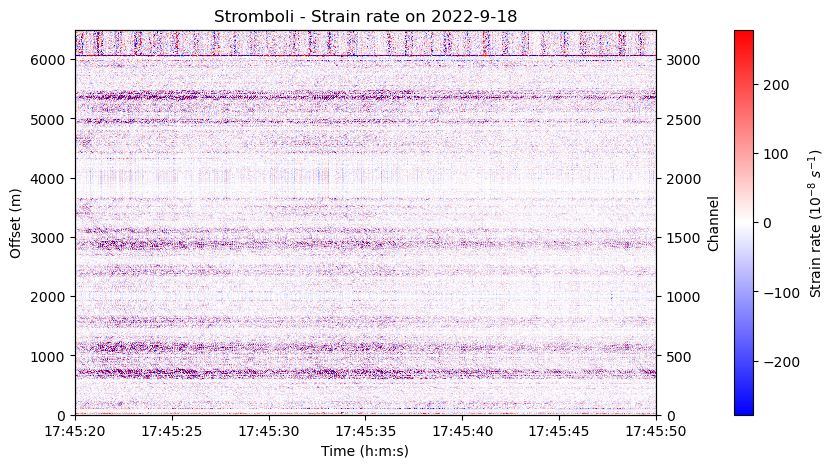

In [168]:
plt.figure(figsize=(10,5))
ax = plt.gca()

im = ax.imshow(vlp_ds['strain_rates'].T, extent=extent_plot, cmap=plt.cm.bwr, 
               interpolation='None', vmin = -extreme, vmax=extreme, origin='lower', aspect='auto')

ax.xaxis_date() 
ax.set_ylabel('Offset (m)')                                                 
ax.set_xlabel('Time (h:m:s)')
ax.set_title('Stromboli - Strain rate on '+ recording_date)

ax2 = ax.twinx()
ax2.set_ylim(vlp_ds['channels'].min(), vlp_ds['channels'].max())
ax2.set_ylabel('Channel')


cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Strain rate ' + r'$(10^{-8}$' + ' ' + r'$ s^{-1})$')

plt.show()

Interpolation: sinc

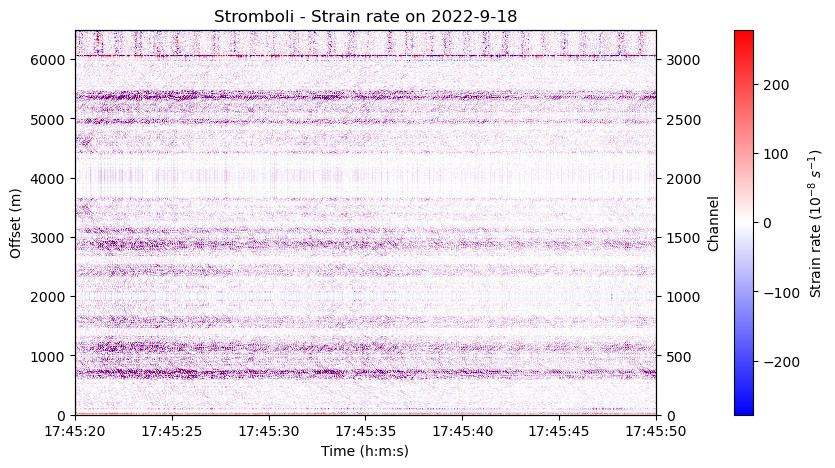

In [118]:
plt.figure(figsize=(10,5))
ax = plt.gca()

im = ax.imshow(vlp_ds['strain_rates'].T, extent=extent_plot, cmap=plt.cm.bwr, 
               interpolation='sinc', vmin = -extreme, vmax=extreme, origin='lower', aspect='auto')

ax.xaxis_date() 
ax.set_ylabel('Offset (m)')                                                 
ax.set_xlabel('Time (h:m:s)')
ax.set_title('Stromboli - Strain rate on '+ recording_date)

ax2 = ax.twinx()
ax2.set_ylim(vlp_ds['channels'].min(), vlp_ds['channels'].max())
ax2.set_ylabel('Channel')


cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Strain rate ' + r'$(10^{-8}$' + ' ' + r'$ s^{-1})$')

plt.show()

Interpolation: bilinear

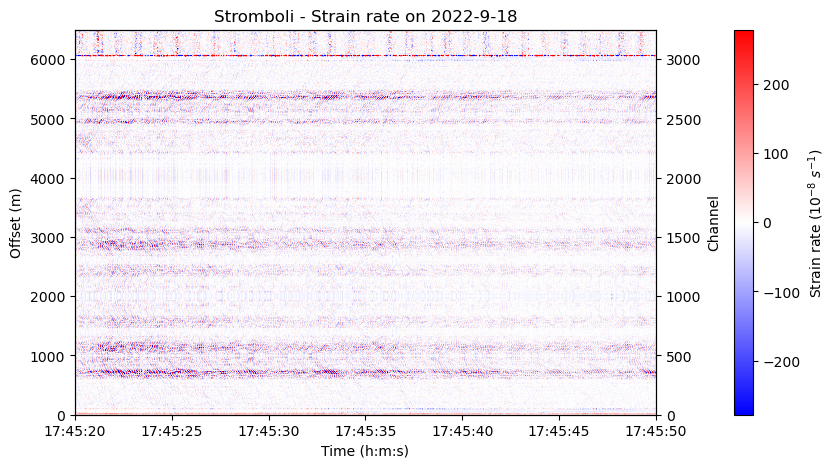

In [119]:
plt.figure(figsize=(10,5))
ax = plt.gca()

im = ax.imshow(vlp_ds['strain_rates'].T, extent=extent_plot, cmap=plt.cm.bwr, 
               interpolation='bilinear', vmin = -extreme, vmax=extreme, origin='lower', aspect='auto')

ax.xaxis_date() 
ax.set_ylabel('Offset (m)')                                                 
ax.set_xlabel('Time (h:m:s)')
ax.set_title('Stromboli - Strain rate on '+ recording_date)

ax2 = ax.twinx()
ax2.set_ylim(vlp_ds['channels'].min(), vlp_ds['channels'].max())
ax2.set_ylabel('Channel')


cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Strain rate ' + r'$(10^{-8}$' + ' ' + r'$ s^{-1})$')

plt.show()

Interpolation: gaussian

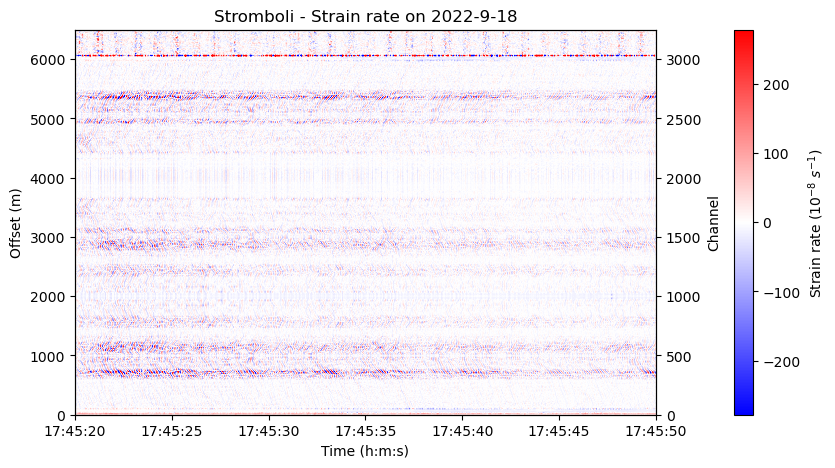

In [120]:
plt.figure(figsize=(10,5))
ax = plt.gca()

im = ax.imshow(vlp_ds['strain_rates'].T, extent=extent_plot, cmap=plt.cm.bwr, 
               interpolation='gaussian', vmin = -extreme, vmax=extreme, origin='lower', aspect='auto')

ax.xaxis_date() 
ax.set_ylabel('Offset (m)')                                                 
ax.set_xlabel('Time (h:m:s)')
ax.set_title('Stromboli - Strain rate on '+ recording_date)

ax2 = ax.twinx()
ax2.set_ylim(vlp_ds['channels'].min(), vlp_ds['channels'].max())
ax2.set_ylabel('Channel')


cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Strain rate ' + r'$(10^{-8}$' + ' ' + r'$ s^{-1})$')

plt.show()

### Graph with filtering (to be reviewed)

Sampling rate (in time and space)

In [121]:

sr = float(np.median(np.diff(das['time'].values.astype('timedelta64[s]').astype(float))))*1e-6 #avant 1e-9, à vérifier  
df = 1/sr # sampling frequency (time)
ssr = float(np.median(np.diff(das['offset'].values)))  
dk = 1/ssr # sampling frequency (space)

dt = np.median(np.diff(das['time'].values)).astype(dtype=np.float64)/1e6  # time step
dx = np.median(np.diff(das['offset'].values))  # space step

In [34]:
df, dk, dt, dx

(50.0, 0.5, 0.02, 2.0)

Filtering

In [129]:
freqmin = .03
freqmax = .3 #VLP limits used by LGS
fe = 0.5 * df
low = freqmin / fe
high = freqmax / fe
corners = 4
z, p, k = iirfilter(corners, [low,high], btype='band',
                        ftype='butter', output='zpk')
sos = zpk2sos(z, p, k)
firstpass = sosfilt(sos,  vlp_ds['strain_rates'].values) #.T ???

If non-causal filtering:

In [36]:
vlp_filt = sosfilt(sos, firstpass[:,::-1])[:,::-1]

If causal filtering:

In [130]:
vlp_filt = sosfilt(sos, firstpass).T

In [131]:
vlp_filt

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.62058701e-24, -3.37041325e-23, -1.30632515e-23],
       [ 1.25739276e-22, -1.15304944e-21, -1.19807100e-21, ...,
         4.33043952e-22, -3.17298594e-22,  7.15143529e-23],
       ...,
       [ 1.53181441e+01, -2.97328227e+01,  6.96129432e+00, ...,
        -2.57961532e+01,  7.54748265e+01,  1.26557962e+01],
       [ 1.63920363e+01, -3.01548759e+01,  6.74227254e+00, ...,
        -2.69442910e+01,  7.77942816e+01,  1.27729609e+01],
       [ 1.74600233e+01, -3.05554786e+01,  6.51840052e+00, ...,
        -2.80784583e+01,  8.00769680e+01,  1.28828606e+01]])

Graph

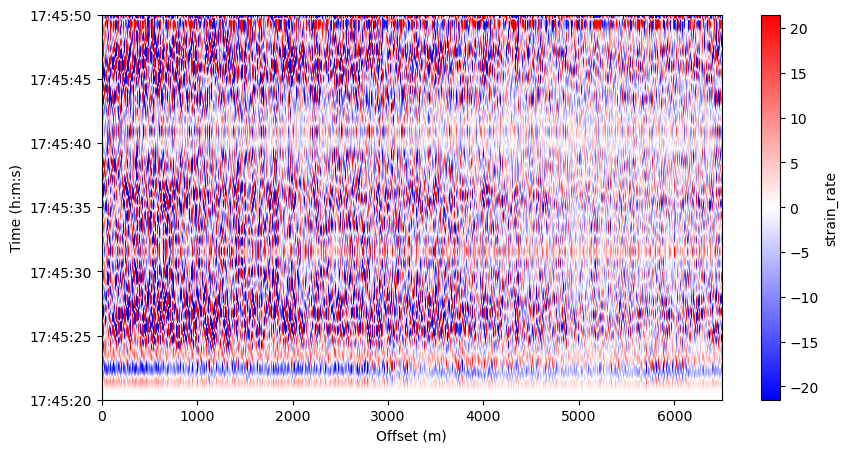

In [132]:
space = np.round(vlp_ds["offsets"].values, 2)
#time = np.array(np.cumsum(np.diff(vlp_ds["times"].values))).astype(dtype=np.float64)*1e-9 - dt
time = np.array(vlp_ds["times"].values)

extent = np.min(space), np.max(space), np.min(time), np.max(time)

#plot
fig, axs = plt.subplots(1,1, figsize=(10, 5),sharey=True,sharex=True)
#cmap = 'seismic'
cmap = plt.cm.bwr
r=10
extreme = np.median(np.array(vlp_array))   + 3*np.std(np.array(vlp_array))

im = axs.imshow(np.array(vlp_filt), extent=extent, aspect='auto', vmin=-np.max(abs(np.array(vlp_filt)))/r, vmax=np.max(abs(np.array(vlp_filt)))/r,
                cmap=cmap, origin='lower', interpolation='sinc')
#im = axs.imshow(np.array(vlp), extent=extent, aspect='auto', vmin=-np.max(abs(np.array(vlp)))/r, 
#                vmax=np.max(abs(np.array(vlp)))/r, cmap=cmap, interpolation='sinc')
#im = axs.imshow(np.array(vlp_array), extent=extent, aspect='auto', vmin=-extreme, vmax=extreme, cmap=cmap, origin='lower', interpolation='sinc')

cbar = plt.colorbar(im, ax=axs)
cbar.set_label('strain_rate')

axs.yaxis_date() 

plt.xlabel('Offset (m)')
plt.ylabel('Time (h:m:s)')
plt.show()